HOME CREDIT는 1997년 체코에 설립된 국제적인 비은행 금융기관으로 14개 국가에서 운영되며 신용기록이 거의 없는 사람들을 대상으로 대출해줍니다. 때문에 고객의 상환 능력을 예측하기위해 거래정보 등 다양한 대체 데이터를 사용하고있습니다.
HOME CREDIT은 고객의 상환 능력을 예측하기위해 다양한 통계 및 머신러닝 방법을 사용하고있지만, Kaggle을 통해 더 나은 예측을 희망하며 August 29, 2018 까지 Home Credit Default Risk Featured Prediction Competition을 시행하고있습니다.

Kaggle에서 제공되는 파일은 application_{train|test}, bureau, bureau_balance, previous_application, POS_CASH_balance, instalments_payments, credit_card_balance 로 총 8가지 입니다. 각 데이터들은 아래와 같은 구조로 key 값들로 서로 연결되어있습니다.


In [1]:
import os
import gc
import time
import numpy as np
import pandas as pd
from contextlib import contextmanager
import multiprocessing as mp
from functools import partial
from scipy.stats import kurtosis, iqr, skew
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 60)

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
debug = True

In [5]:
num_rows = 30000 if debug else None

In [6]:
# df = get_train_test(DATA_DIRECTORY, num_rows = num_rows)

In [7]:
NUM_THREADS = 4
DATA_DIRECTORY = "input"
SUBMISSION_SUFIX = "_model2_04"

In [8]:
path = DATA_DIRECTORY
num_rows = num_rows

In [9]:
train = pd.read_csv(os.path.join(path, 'application_train.csv'), nrows = num_rows)
test = pd.read_csv(os.path.join(path, 'application_test.csv'), nrows = num_rows)

In [10]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

<AxesSubplot:>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


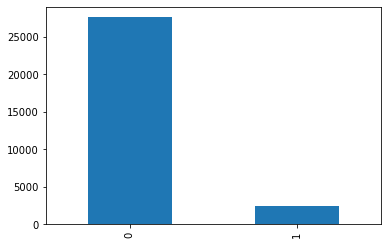

In [11]:
train['TARGET'].value_counts().plot.bar() #불균형

In [12]:
df = train.append(test)

In [13]:
del train, test;

In [14]:
gc.collect()

60

## preprocessing

EDA 참고 노트북: [
Home Credit Default Risk Extensive EDA](https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda)

In [15]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [16]:
print(os.listdir(path))

['application_test.csv', 'application_train.csv', 'baseline_lgb.csv', 'baseline_lgb_domain_features.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'log_reg_baseline.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'random_forest_baseline.csv', 'random_forest_baseline_domain.csv', 'random_forest_baseline_engineered.csv', 'sample_submission.csv']


In [17]:
bureau = pd.read_csv(path+"/bureau.csv")
bureau_balance = pd.read_csv(path+"/bureau_balance.csv")
credit_card_balance = pd.read_csv(path+"/credit_card_balance.csv")
installments_payments = pd.read_csv(path+"/installments_payments.csv")
previous_application = pd.read_csv(path+"/previous_application.csv")
POS_CASH_balance = pd.read_csv(path+"/POS_CASH_balance.csv")

#### DATA MODEL

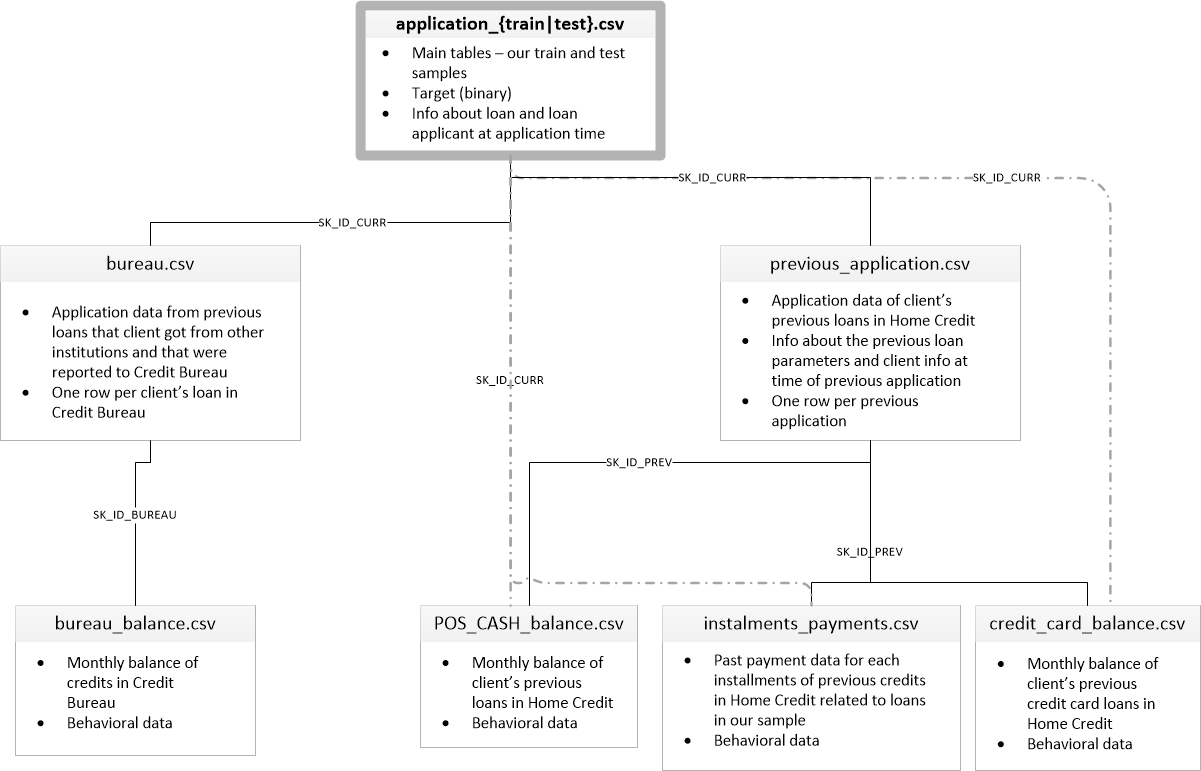

In [18]:
from IPython.display import Image, display
display(Image(filename='home_credit.png', embed=True))

파일들 간의 연결 구조를 보면 application_{train|test}를 기준으로 왼쪽으로는 신용 관리국에 보고 된 다른 금융 기관에서 제공한 모든 고객의 이전 크레딧에 관한 정보가 나타나있고, 오른쪽으로는 샘플에 있는 고객의 이전 주택 대출에대한 정보가 있습니다.

SK_ID_CURR is connecting the dataframes application_train|test with bureau, previous_application and also with dataframes POS_CASH_balance, installments_payment and credit_card_balance. SK_ID_PREV connects dataframe previous_application with POS_CASH_balance, installments_payment and credit_card_balance. SK_ID_BUREAU connects dataframe bureau with dataframe bureau_balance.

### Glimpse the data

In [19]:
train = pd.read_csv(os.path.join(path, 'application_train.csv'))
test = pd.read_csv(os.path.join(path, 'application_test.csv'))

In [20]:
print("application_train -  rows:",train.shape[0]," columns:", train.shape[1])
print("application_test -  rows:",test.shape[0]," columns:", test.shape[1])
print("bureau -  rows:",bureau.shape[0]," columns:", bureau.shape[1])
print("bureau_balance -  rows:",bureau_balance.shape[0]," columns:", bureau_balance.shape[1])
print("credit_card_balance -  rows:",credit_card_balance.shape[0]," columns:", credit_card_balance.shape[1])
print("installments_payments -  rows:",installments_payments.shape[0]," columns:", installments_payments.shape[1])
print("previous_application -  rows:",previous_application.shape[0]," columns:", previous_application.shape[1])
print("POS_CASH_balance -  rows:",POS_CASH_balance.shape[0]," columns:", POS_CASH_balance.shape[1])

application_train -  rows: 307511  columns: 122
application_test -  rows: 48744  columns: 121
bureau -  rows: 1716428  columns: 17
bureau_balance -  rows: 27299925  columns: 3
credit_card_balance -  rows: 3840312  columns: 23
installments_payments -  rows: 13605401  columns: 8
previous_application -  rows: 1670214  columns: 37
POS_CASH_balance -  rows: 10001358  columns: 8


In [21]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

In [22]:
train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

In [23]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,...,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.1974,0.9970,0.9592,0.1165,0.32,0.2759,...,0.3081,0.1974,0.9970,0.9597,0.1173,0.32,0.2759,0.375,0.0417,0.2078,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0

In [24]:
test.columns.values

array(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG'

In [25]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [26]:
bureau.columns.values

array(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'], dtype=object)

In [27]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [28]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [29]:
credit_card_balance.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE',
       'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT',
       'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT',
       'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM',
       'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF'], dtype=object)

In [30]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
previous_application.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
       'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA',
       'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'], dtype=object)

In [32]:
POS_CASH_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [33]:
POS_CASH_balance.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'], dtype=object)

### Check missing data

In [34]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending  =False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [35]:
missing_data(train).head(10)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


In [36]:
missing_data(test).head(10)

,Total,Percent
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MODE,33495,68.716150
COMMONAREA_MEDI,33495,68.716150
NONLIVINGAPARTMENTS_AVG,33347,68.412523
NONLIVINGAPARTMENTS_MODE,33347,68.412523
NONLIVINGAPARTMENTS_MEDI,33347,68.412523
FONDKAPREMONT_MODE,32797,67.284179
LIVINGAPARTMENTS_AVG,32780,67.249302
LIVINGAPARTMENTS_MODE,32780,67.249302
LIVINGAPARTMENTS_MEDI,32780,67.249302


In [37]:
missing_data(bureau)

,Total,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
CREDIT_ACTIVE,0,0.000000
CREDIT_CURRENCY,0,0.000000
DAYS_CREDIT,0,0.000000


In [38]:
missing_data(bureau_balance)

,Total,Percent
SK_ID_BUREAU,0,0.0
MONTHS_BALANCE,0,0.0
STATUS,0,0.0


### credit_card_balance

In [39]:
missing_data(credit_card_balance)

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208
SK_ID_PREV,0,0.000000


### installments_payments


In [40]:
missing_data(installments_payments)

,Total,Percent
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_PAYMENT,2905,0.021352
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
NUM_INSTALMENT_VERSION,0,0.000000
NUM_INSTALMENT_NUMBER,0,0.000000
DAYS_INSTALMENT,0,0.000000
AMT_INSTALMENT,0,0.000000


### previous_application

In [41]:
missing_data(previous_application).head(20)

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
AMT_DOWN_PAYMENT,895844,53.636480
RATE_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_TERMINATION,673065,40.298129
DAYS_LAST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129


### POS_CASH_balance


In [42]:
missing_data(POS_CASH_balance)

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
NAME_CONTRACT_STATUS,0,0.000000
SK_DPD,0,0.000000
SK_DPD_DEF,0,0.000000


## Check data unbalance

TARGET value 0 means loan is repayed, value 1 means loan is not repayed.

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


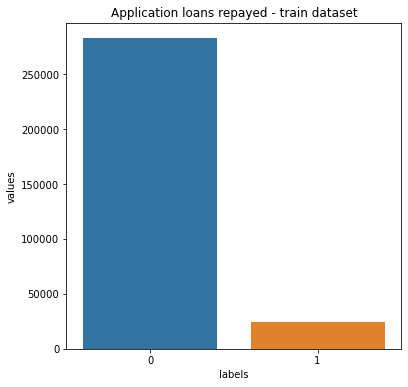

In [43]:
temp = train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('Application loans repayed - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

## Explore the data

Let's see the type of the loans taken and also, on a separate plot, the percent of the loans (by type of the loan) with TARGET value 1 (not returned loan).

In [44]:
def plot_stats(feature, label_rotation = False, horizontal_layout = True):
    temp = train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})
    
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[feature, 'TARGET']].groupby([feature], as_index = False).mean()
    cat_perc.sort_values(by = 'TARGET', ascending = False, inplace = True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize = (12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

In [45]:
def plot_distribution(var):
    
    i = 0
    t1 = application_train.loc[application_train['TARGET'] != 0]
    t0 = application_train.loc[application_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

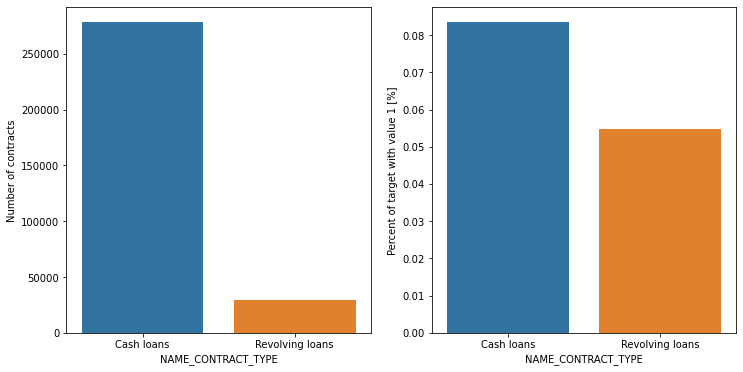

In [46]:
plot_stats('NAME_CONTRACT_TYPE')

Contract type Revolving loans are just a small fraction (10%) from the total number of loans; in the same time, a larger amount of Revolving loans, comparing with their frequency, are not repaid.

### Client gender
Let's see the gender of the clients and also, on a separate plot, the percent of the loans (by client gender) with TARGET value 1 (not returned loan).

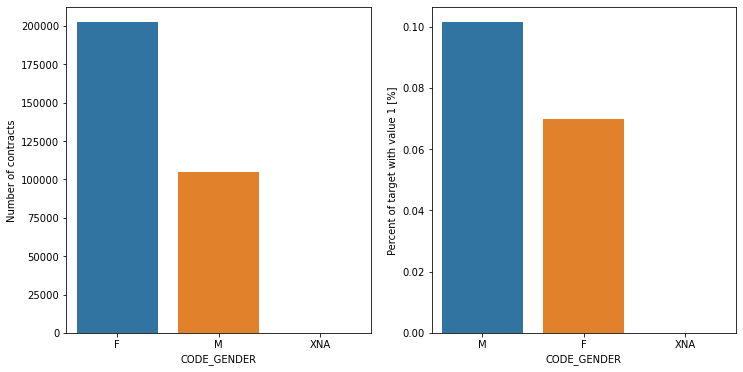

In [47]:
plot_stats('CODE_GENDER')

The number of female clients is almost double the number of male clients. Looking to the percent of defaulted credits, males have a higher chance of not returning their loans (~10%), comparing with women (~7%).

### Flag own car and flag own real estate
Let's inspect the flags that tell us if a client owns a car or real estate and, on separate plots, the percent of the loans value of these flags) with TARGET value 1 (not returned loan).

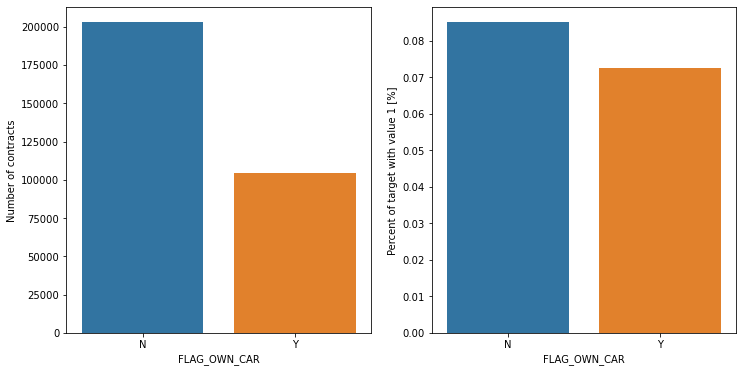

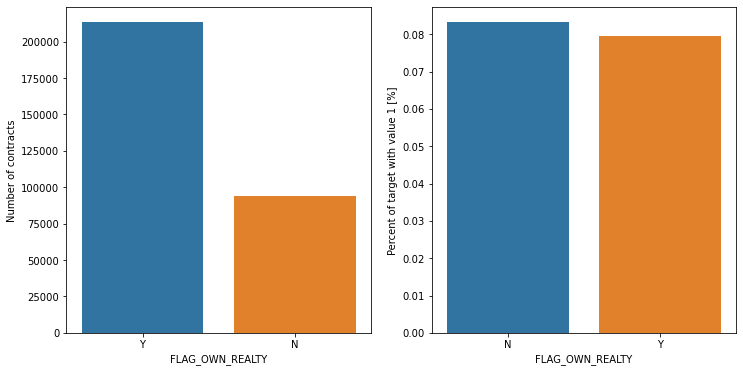

In [48]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

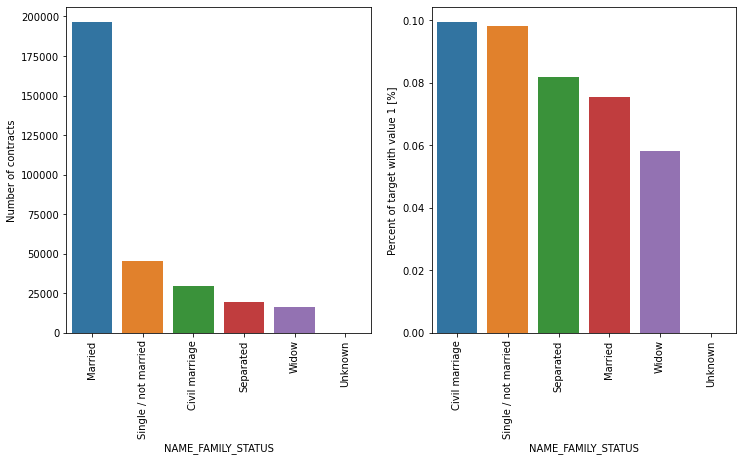

In [49]:
plot_stats('NAME_FAMILY_STATUS',True, True)

Most of clients are married, followed by Single/not married and civil marriage.

In terms of percentage of not repayment of loan, Civil marriage has the highest percent of not repayment (10%), with Widow the lowest (exception being Unknown).

### Number of Children

Let's see what is the distribution of the number of children of clients.

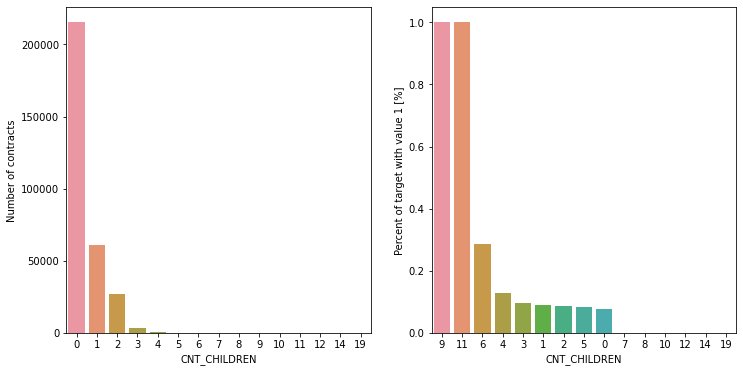

In [50]:
plot_stats('CNT_CHILDREN')

대출을 받는 대부분의 고객은 자녀가 없습니다. 자녀가 1명인 고객과 관련된 대출 건수는 4배, 자녀가 2명인 고객과 관련된 대출 건수는 8배 적습니다. 3, 4 또는 그 이상의 자녀를 둔 고객은 훨씬 더 드뭅니다.

상환에 관해서는 자녀가 없는 고객, 1, 2, 3, 5명의 자녀가 없는 고객은 평균(10%) 정도의 미상환 비율을 가지고 있습니다. 4, 6자녀를 둔 고객들은 대출금을 갚지 못한 비율이 평균 이상입니다(6자녀 가정의 경우 25% 이상).

자녀가 9명 또는 11명인 고객의 경우 대출 미상환 비율이 100%입니다.

### Number of family members of client

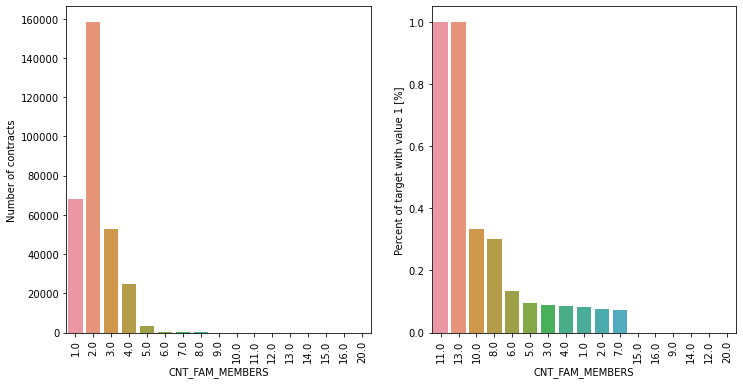

In [51]:
plot_stats('CNT_FAM_MEMBERS',True)

가족구성원이 2명인 고객이 가장 많고 그 다음이 1명(독신자), 3명(자녀가 있는 가족), 4명이다.

11,13인 가족의 고객은 무상환율 100%입니다. 다른 10인, 8인 가구는 대출금을 상환하지 못하는 비율이 30%를 넘습니다. 6인 이하 가정의 경우 상환율이 평균 10%에 가깝습니다.

### 고객의 소득 유형
소득 유형이 다른 고객의 수를 조사해 보겠습니다. 또한, 소득 유형별 신청자의 미지급률을 살펴보겠습니다.

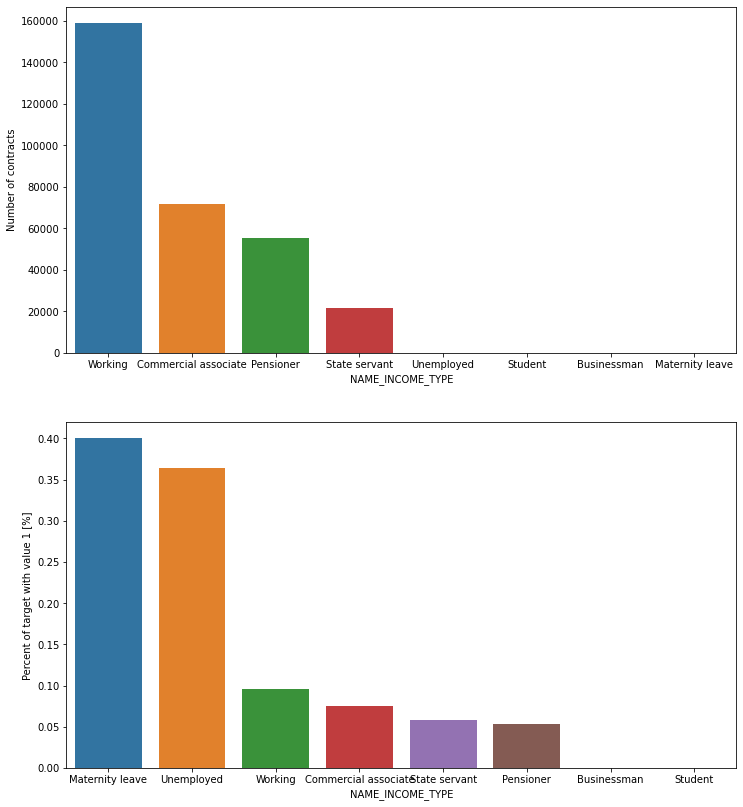

In [52]:
plot_stats('NAME_INCOME_TYPE',False,False)

대출 신청자의 대부분은 근로 소득이며 상업 직원, 연금 수급자 및 국가 공무원이 그 뒤를 잇습니다.

소득유형 출산휴가 신청자는 대출금을 갚지 않는 비율이 거의 40%에 육박하고 실업자(37%)가 그 뒤를 이었다. 나머지 소득 유형은 대출금을 갚지 않아 평균 10% 미만이다.

### Ocupation of client

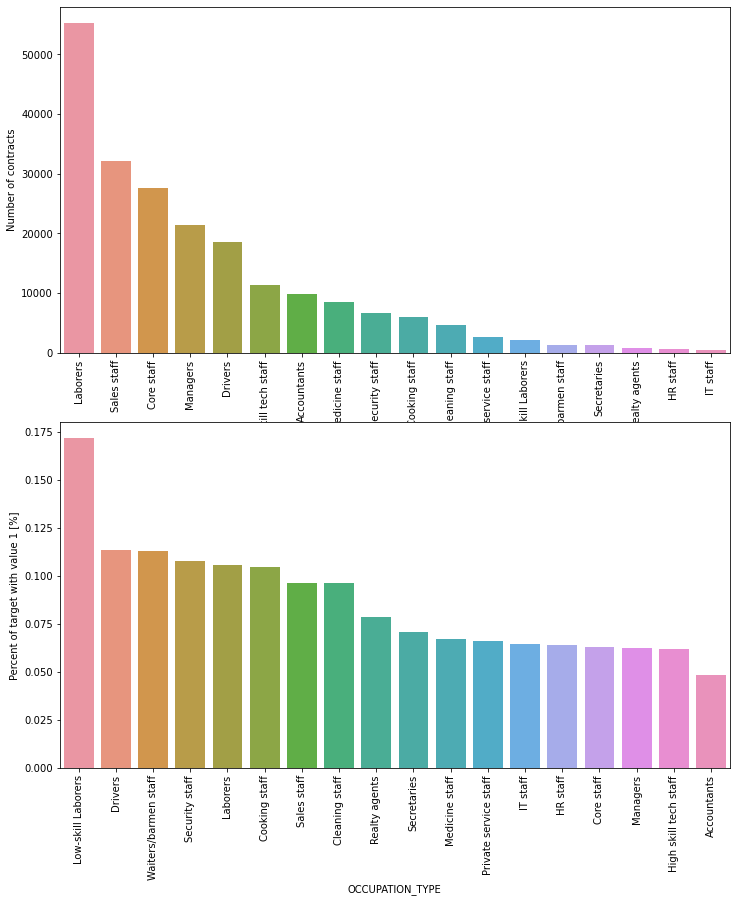

In [53]:
plot_stats('OCCUPATION_TYPE',True, False)

대부분의 대출은 근로자가 받고 그 다음이 영업 직원입니다. IT 직원은 가장 낮은 금액의 대출을 받습니다.

상환되지 않은 대출의 비율이 가장 높은 범주는 저숙련 노동자(17% 이상)이며 운전기사 및 웨이터/바텐더 직원, 보안 직원, 노동자 및 요리 직원이 그 뒤를 잇습니다.

### Organization type

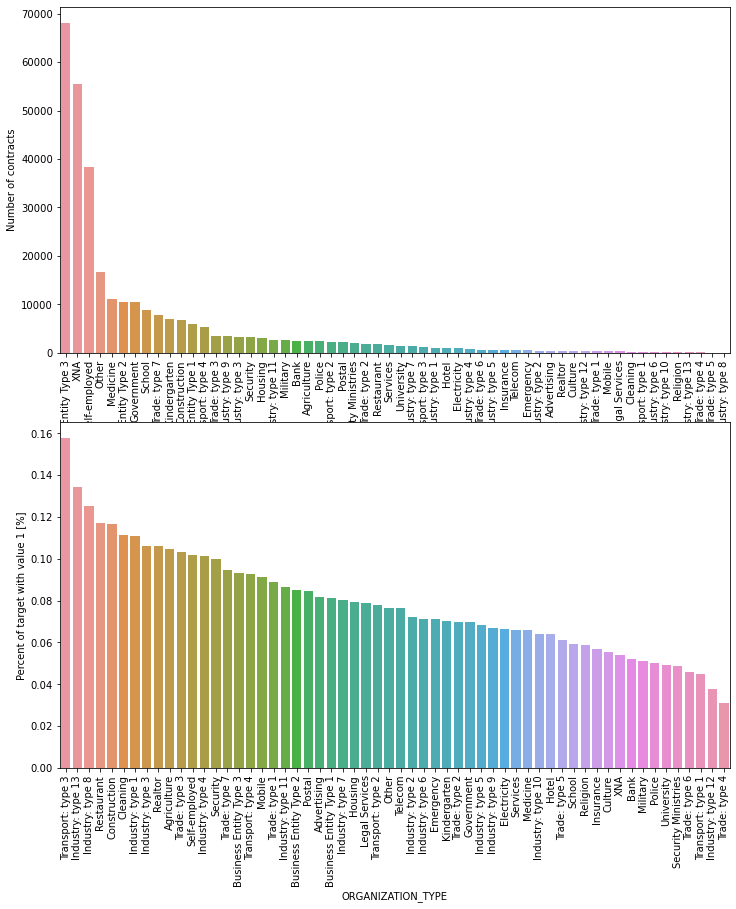

In [54]:
plot_stats('ORGANIZATION_TYPE',True, False)

대출 미상환 비율이 가장 높은 조직은 운송: 3종(16%), 산업: 13(13.5%), 산업: 8(12.5%) 및 레스토랑(12% 미만)입니다.
### Education type of the client

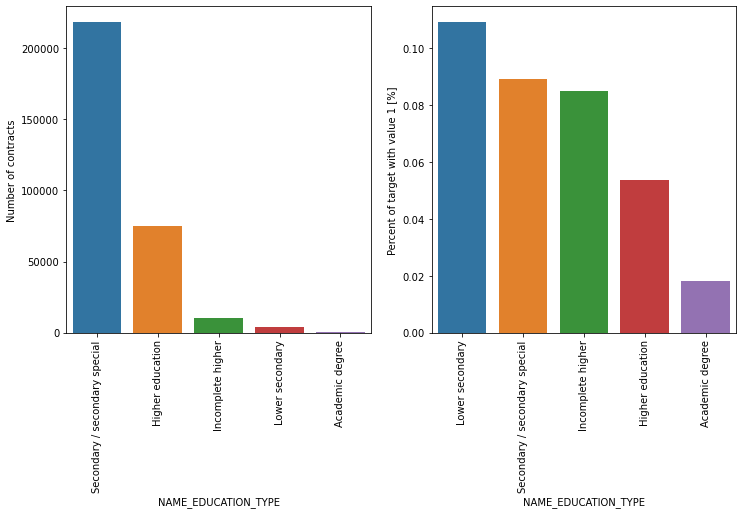

In [55]:
plot_stats('NAME_EDUCATION_TYPE',True)

고객의 대다수는 중등/중등 특수 교육을 받았으며 그 다음은 고등 교육을 받은 고객입니다. 학사 학위를 가진 극소수에 불과합니다.

하위 2차 범주는 드물지만 대출을 반환하지 않는 비율이 가장 높습니다(11%). 학사학위 소지자는 미납율 2% 미만

### Type of the housing of client

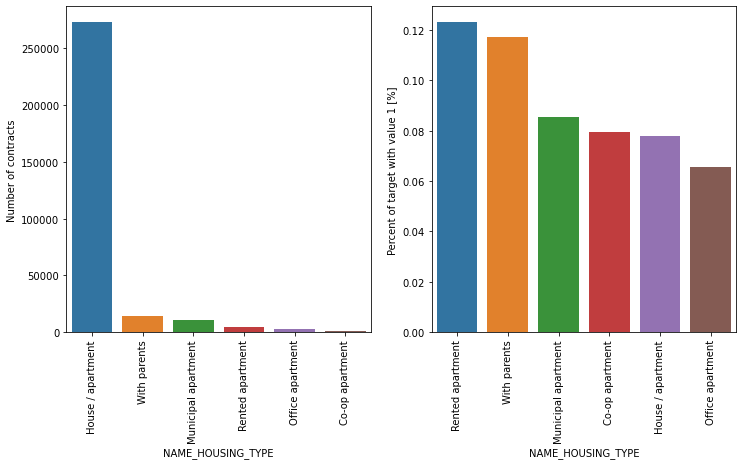

In [56]:
plot_stats('NAME_HOUSING_TYPE',True)

250,000명 이상의 크레딧 신청자가 주택/아파트로 주택을 등록했습니다. 다음 카테고리는 클라이언트 수가 매우 적습니다(부모와 함께, 시립 아파트).

이 범주에서 임대아파트와 부모동반은 미상환율이 10% 이상입니다.

### Total income distribution
고객의 총 소득 분포를 플롯해 보겠습니다.

In [57]:
# Plot distribution of one feature
def plot_distribution(feature, color):
    plt.figure(figsize = (10,6))
    plt.title("Distribution of %s" %feature)
    sns.distplot(train[feature].dropna(), color=color, kde=True, bins=100)
    plt.show

In [58]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var, nrow=2):
    
    i = 0
    t1 = train.loc[train['TARGET'] != 0]
    t0 = train.loc[train['TARGET'] == 0]
    
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow, 2,figsize=(12, 6*nrow))
    
    for feature in var:
        i += 1
        plt.subplot(nrow,2, i)
        sns.kdeplot(t1[feature], bw=0.5, label='TARGET = 1')
        sns.kdeplot(t0[feature], bw=0.5, label='TARGET = 0')
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

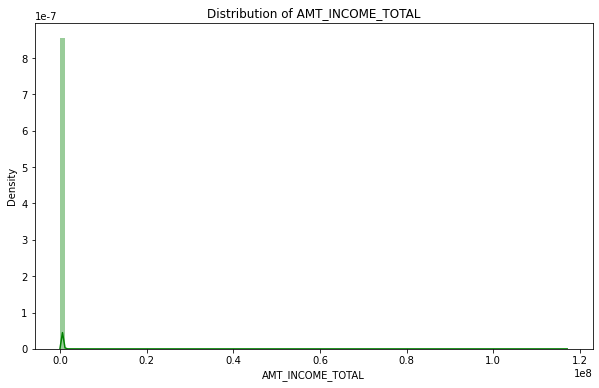

In [59]:
plot_distribution('AMT_INCOME_TOTAL','green')

### Credit distribution
Let's plot the credit distribution.

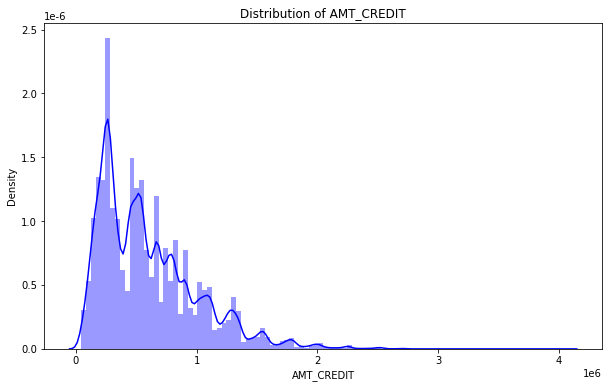

In [60]:
plot_distribution('AMT_CREDIT','blue')

### Annuity distribution (연금분배)
Let's plot the annuity distribution.

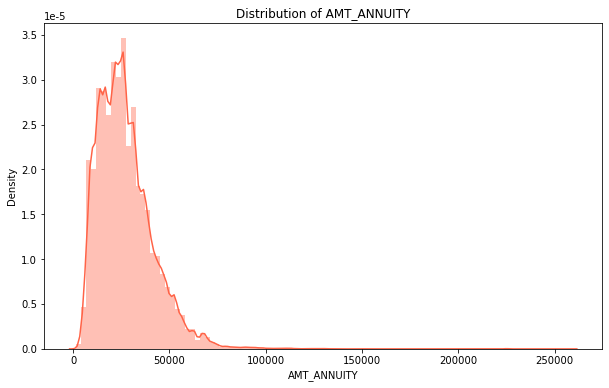

In [61]:
plot_distribution('AMT_ANNUITY','tomato')

### Goods price
Let's plot the good price distribution.

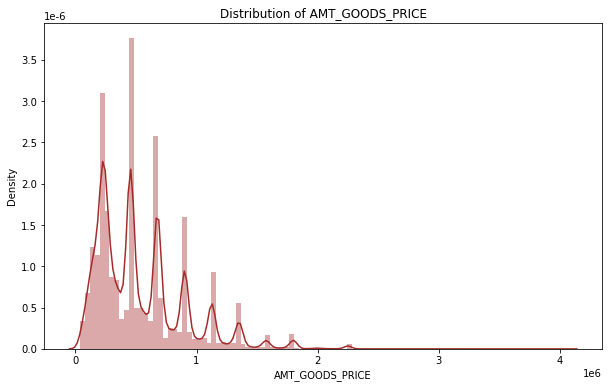

In [62]:
plot_distribution('AMT_GOODS_PRICE','brown')

### Days from birth distribution
Let's plot the distribution number of days from birth.

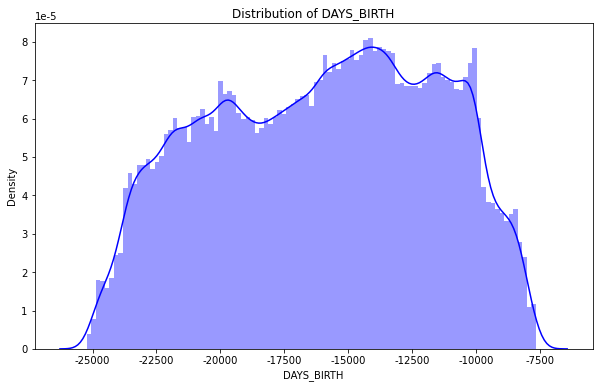

In [63]:
plot_distribution('DAYS_BIRTH','blue')

음수 값은 생년월일이 과거임을 의미합니다. 연령 범위는 대략 20세에서 68세 사이입니다.

### Days employed distribution
Let's represent the distribution of number of days employed.

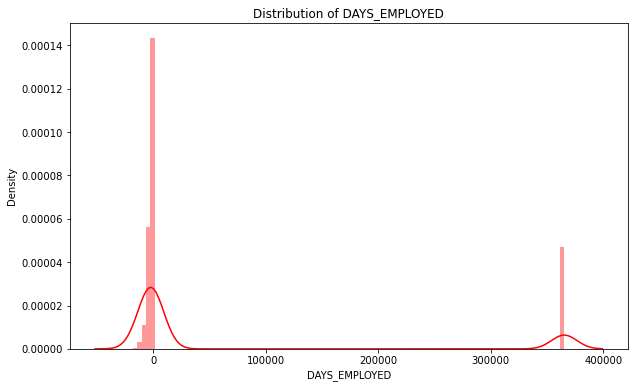

In [64]:
plot_distribution('DAYS_EMPLOYED','red')

음수 값은 고용된 이후 일수를 의미하고 대부분의 경우 이러한 음수 값은 실업자를 의미합니다. 맨 끝에 있는 매우 큰 숫자의 의미가 무엇인지는 분명하지 않습니다(100년 이상 고용된 사람들이 그렇게 많은 것은 현실적이지 않습니다).

### Days of registration distribution
Let's plot the distribution of DAYS_REGISTRATION.

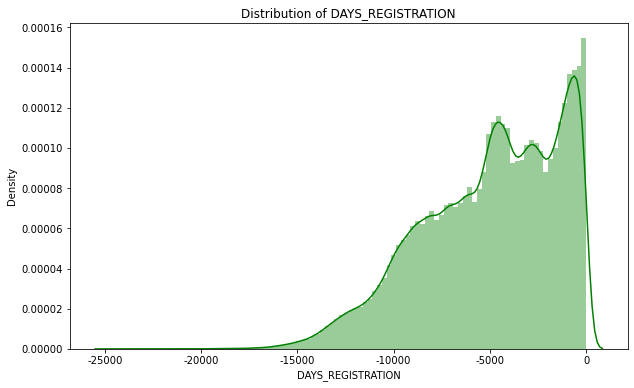

In [65]:
plot_distribution('DAYS_REGISTRATION','green')

### Days ID publish distribution
Let's plot the distribution of DAYS_ID_PUBLISH.

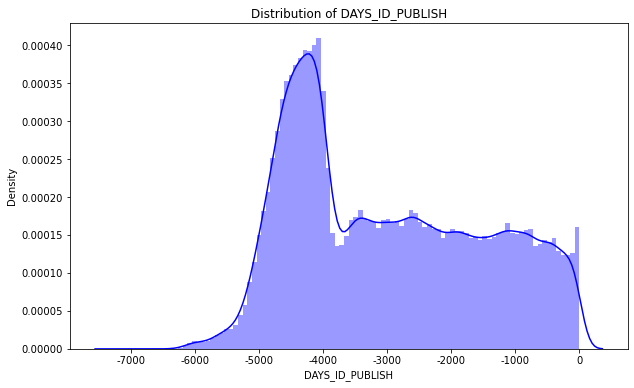

In [66]:
plot_distribution('DAYS_ID_PUBLISH','blue')

### Comparison of interval values with TARGET = 1 and TARGET = 0
Let's compare the distribution of interval values ploted above for values of TARGET = 1 and TARGET = 0

<Figure size 432x288 with 0 Axes>

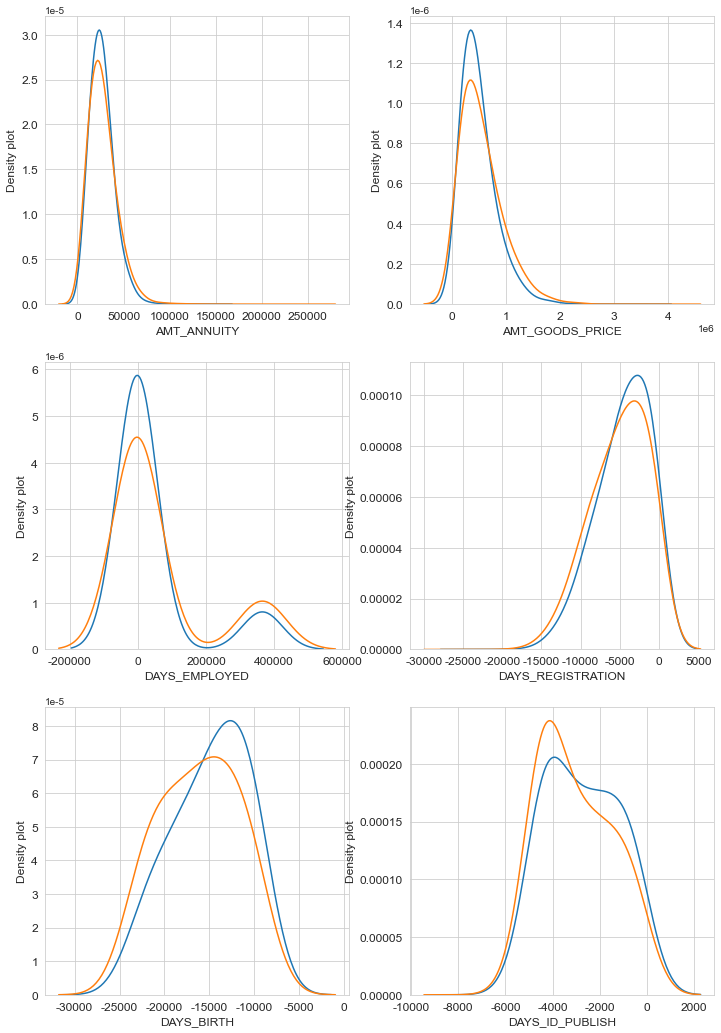

In [67]:
var = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED', 'DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH']
plot_distribution_comp(var,nrow=3)

### Region registered not live region and not work region
Let's represent the values of region registered and not live region and region registered and not work region.

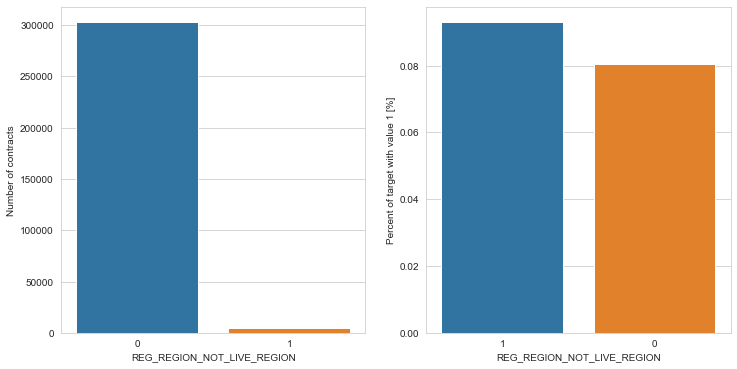

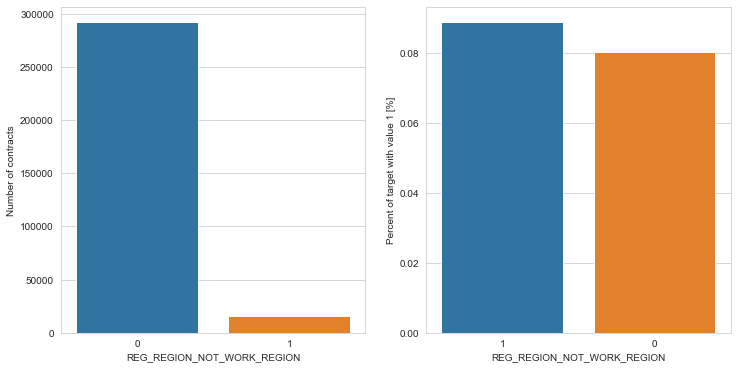

In [68]:
plot_stats('REG_REGION_NOT_LIVE_REGION')
plot_stats('REG_REGION_NOT_WORK_REGION')

살고 있지 않거나 일하지 않는 지역에 등록된 사람은 거의 없습니다. 일반적으로 이러한 경우에 반환하지 않는 비율이 나머지보다 약간 더 큽니다(약 8%와 비교하여 8% 약간 초과).

### City registered not live city and not work city
Let's represent the values of City registered not live city and not work city.

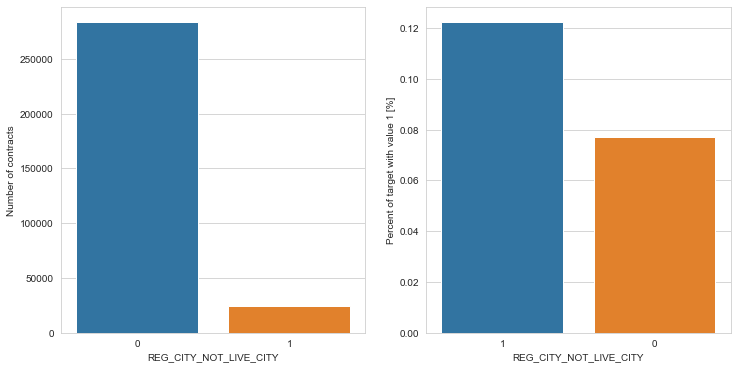

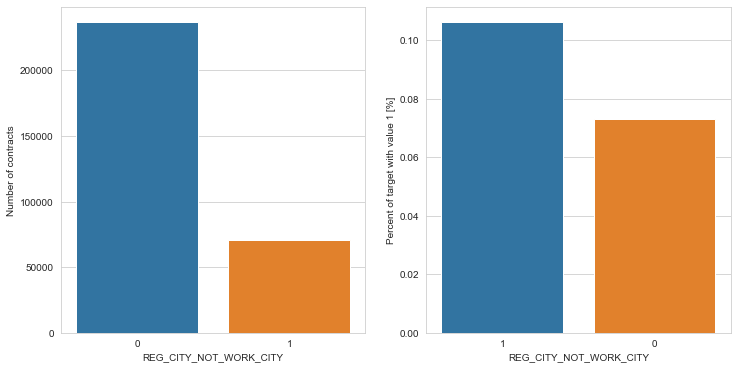

In [69]:
plot_stats('REG_CITY_NOT_LIVE_CITY')
plot_stats('REG_CITY_NOT_WORK_CITY')

일반적으로 훨씬 더 많은 사람들이 거주하거나 일하는 도시에 등록합니다(많은 수의 사람들이 거주하는 도시와 일하는 도시에서 다르게 등록).

일하는 도시나 거주하는 도시와 다른 도시에 등록한 사람들은 같은 도시에 등록한 사람들보다 대출을 더 자주 갚지 않습니다(직장 11% 또는 생활 12%).

### Bureau data
Bureau data contains all client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in the sample). For every loan in the sample, there are as many rows as number of credits the client had in Credit Bureau before the application date. SK_ID_CURR is the key connecting application_train|test data with bureau data.

Let's merge application_train with bureau.

In [70]:
bureau_train = train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [71]:
print("The resulting dataframe `bureau_train` has ",bureau_train.shape[0]," rows and ", 
      bureau_train.shape[1]," columns.")

The resulting dataframe `bureau_train` has  1465325  rows and  138  columns.


In [72]:
def plot_b_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = bureau_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = bureau_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

### Credit status
Let's see the credit status distribution. We show first the number of credits per category (could be Closed, Active, Sold and Bad debt).

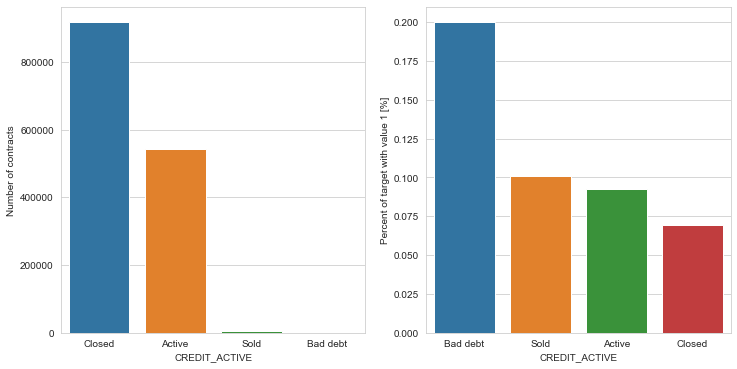

In [73]:
plot_b_stats('CREDIT_ACTIVE')

Credit Bureau에 등록된 대부분의 크레딧은 Closed(~900K) 상태입니다. 두 번째 장소는 활성 크레딧(600K 미만)입니다. 매각된 부채와 불량 부채는 극히 일부에 불과합니다.

동시에, 카테고리별 총 수에서 TARGET = 1인 비율로 신용 조사 기관에 신용 불량자로 등록된 고객은 현재 응용 프로그램에 대해 20%의 채무 불이행을 가집니다.

Sold, Active 및 Closed 크레딧이 있는 클라이언트는 TARGET == 1(기본 크레딧)의 백분율이 10%(전체 비율은 10%)와 같거나 작습니다. 기본 신용의 최소 비율은 신용이 있는 고객이 신용 관리국에 신용 마감 상태로 등록되어 있습니다.

즉, 이전에 등록된 신용 기록(신용 관리국에 등록된 대로)이 기본 신용에 대한 강력한 예측 변수임을 의미합니다. 불량 부채 이력이 있는 채무 불이행 신청 비율은 판매 또는 활성 상태의 경우보다 두 배, 폐쇄를 위해.

### Credit currency
Let's check now the number of credits registered at the Credit Bureau with different currencies. Also, let's check procent of defaulting credits (for current applications) per different currencies of credits credits registered at the Credit Bureau in the past for the same client.

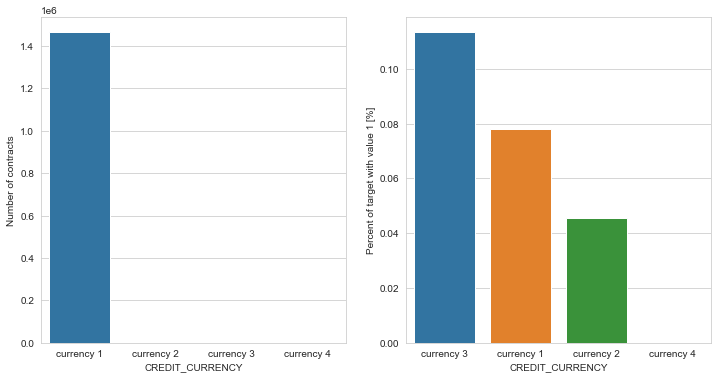

In [74]:
plot_b_stats('CREDIT_CURRENCY')

### Credits are mostly in currency_1.

Depending on the currency, the percent of clients defaulting is quite different. Starting with currency_3, then currency_1 and currency_2, the percent of clients defaulting is 11%, 8% and 5%. Percent of defaulting applications for clients that have credits registered with currency_4 is close to 0.

### Credit type
Let's check now the credit types for credits registered at the Credit Bureau.

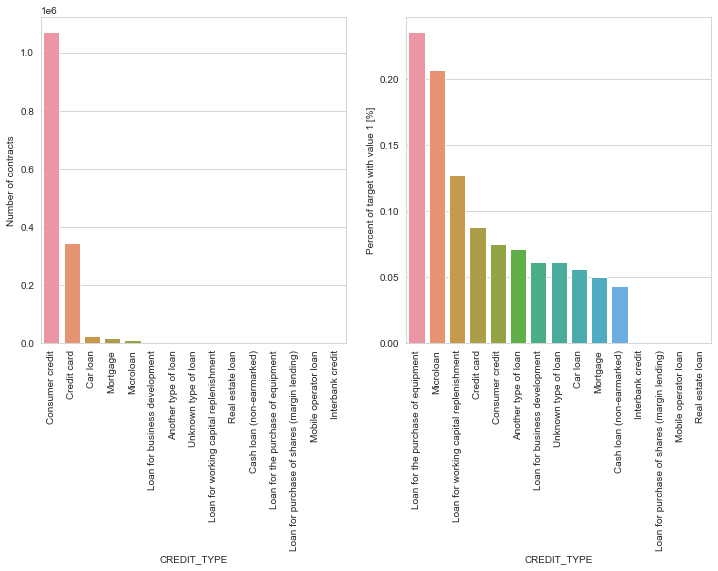

In [75]:
plot_b_stats('CREDIT_TYPE', True, True)

신용조사국에 등록된 대부분의 역사적 신용은 소비자 신용과 신용카드입니다. 신용의 더 적은 수는 자동차 대출, 모기지 및 소액 대출입니다.

이제 신용 조사국에 등록된 과거 신용 유형을 살펴보면 다음과 같이 현재 신용 채무 불이행 비율이 높은 유형이 거의 없습니다.

장비 구입을 위한 대출 - 현재 크레딧이 20% 이상 부도 상태입니다.
소액 대출 - 현재 크레딧이 20% 이상 부도 상태입니다.
운전 자본 보충을 위한 대출 - 현재 12% 이상의 신용 불이행 상태입니다.

### Duration of credit (DAYS_CREDIT)
Let's check the distribution of number of days for the credit (registered at the Credit bureau).

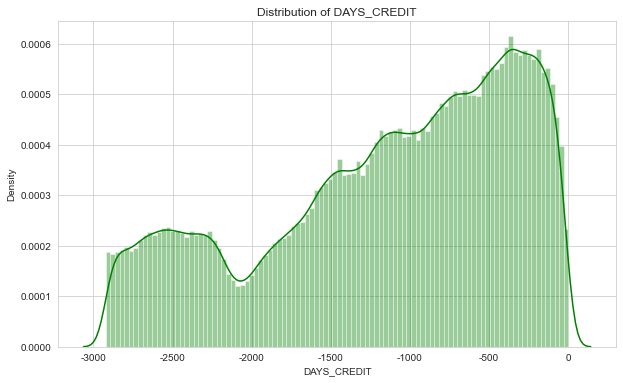

In [76]:
def plot_b_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(bureau_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show() 
    
plot_b_distribution('DAYS_CREDIT','green')

크레딧 기간(일)은 3000일 미만(현지 안장은 약 2000일) 범위이며 더 짧은 기간 동안 빈도가 증가하며 최대 약 300일(또는 1년 미만)입니다.

### Credit overdue (CREDIT_DAY_OVERDUE)
Let's check the distribution of number of days for the credit overdue (registered at the Credit bureau).

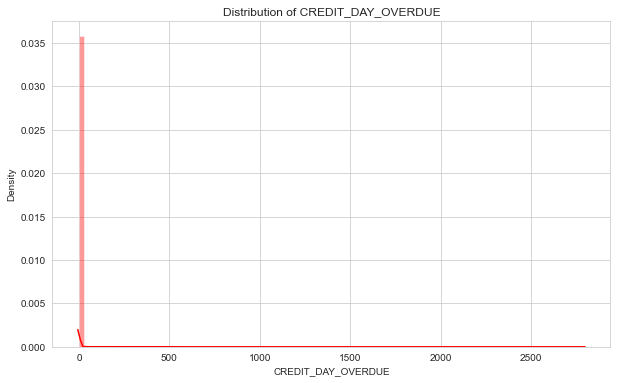

In [77]:
plot_b_distribution('CREDIT_DAY_OVERDUE','red')

Most of the credits have 0 or close to 0 days overdue. The maximum number of credit days overdue is ~3000 days.

### Credit sum (AMT_CREDIT_SUM)

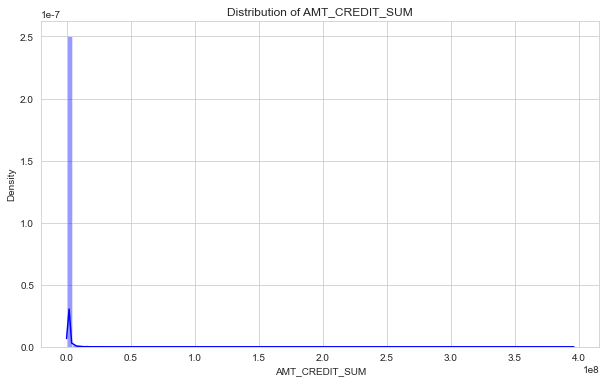

In [78]:
plot_b_distribution('AMT_CREDIT_SUM','blue')

AMT_CREDIT_SUM의 분포는 낮은 크레딧 합계 범위에 대한 크레딧의 집중을 보여줍니다.

0 부근의 분포를 더 잘 볼 수 있도록 이상치를 제거합시다.

이상값(미리 정의된 임계값 포함)을 식별하고 필터링하는 함수를 소개하겠습니다.

그런 다음, 이번에는 이상값을 필터링하는 함수를 사용하여 분포를 표시하도록 함수를 수정해 보겠습니다.

In [79]:
# Source: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting (see references)

def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    
    modified_z_score = 0.6745 * diff / med_abs_deviation
    
    return modified_z_score > thresh

def plot_b_o_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    x = bureau_train[feature].dropna()
    filtered = x[~is_outlier(x)]
    sns.distplot(filtered,color=color, kde=True,bins=100)
    plt.show() 


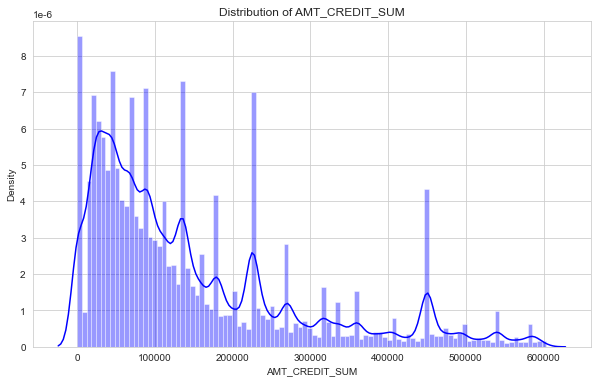

In [80]:
plot_b_o_distribution('AMT_CREDIT_SUM','blue')

We can observe that the distribution function shows several peaks and the maximum concentration of the values is around 20,000 but we also see several other peaks at higher values.

### Credit sum limit (AMT_CREDIT_SUM_LIMIT)

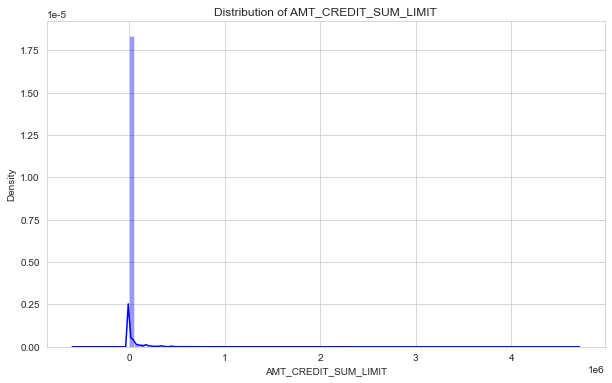

In [81]:
plot_b_distribution('AMT_CREDIT_SUM_LIMIT','blue')

### Comparison of interval values with TARGET = 1 and TARGET = 0
Let's compare the distribution of interval values ploted above for values of TARGET = 1 and TARGET = 0

In [89]:
def plot_b_distribution_comp(var, nrow=2):
    
    i = 0
    t1 = bureau_train.loc[bureau_train['TARGET'] !=0]
    t0 = bureau_train.loc[bureau_train['TARGET'] ==0]
    
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow, 2, figsize=(12,6*nrow))
    
    for feature in var:
        i += 1
        plt.subplot(nrow, 2, i)
        sns.kdeplot(t1[feature], bw=0.5, label = 'TARGET = 1')
        sns.kdeplot(t0[feature], bw=0.5, label = 'TARGET = 0')
        plt.ylabel('Density plot', fontsize = 12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis = 'both', which='major', labelsize=12)
    plt.show()

<Figure size 432x288 with 0 Axes>

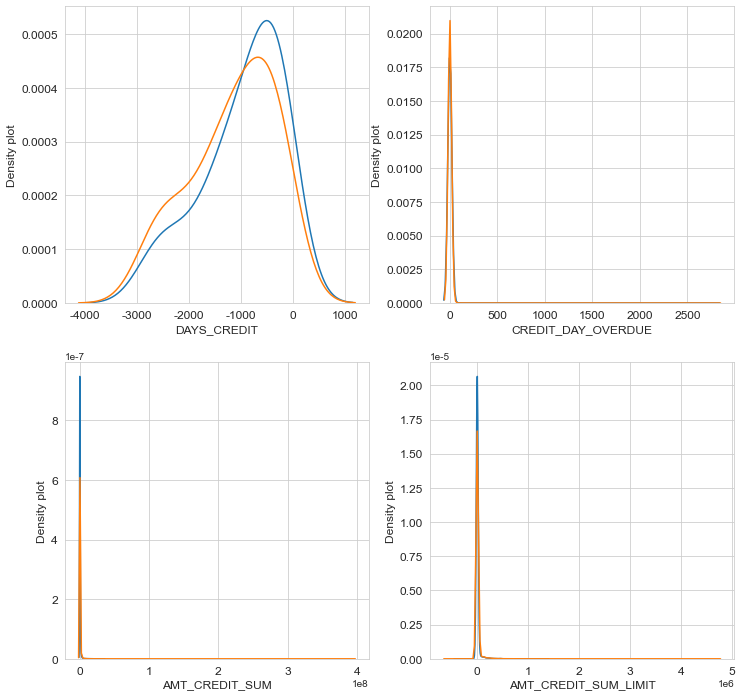

In [90]:
var = ['DAYS_CREDIT','CREDIT_DAY_OVERDUE','AMT_CREDIT_SUM','AMT_CREDIT_SUM_LIMIT']

plot_b_distribution_comp(var, nrow=2)

### Previous application data
The dataframe previous_application contains information about all previous applications for Home Credit loans of clients who have loans in the sample. There is one row for each previous application related to loans in our data sample. SK_ID_CURR is the key connecting application_train|test data with previous_application data.


Let's merge application_train with previous_application.

In [91]:
application_prev_train = train.merge(previous_application, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [92]:
print("The resulting dataframe `application_prev_train` has ",application_prev_train.shape[0]," rows and ", 
      application_prev_train.shape[1]," columns.")

The resulting dataframe `application_prev_train` has  1413701  rows and  158  columns.


In [93]:
def plot_p_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_prev_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_prev_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

### Contract type

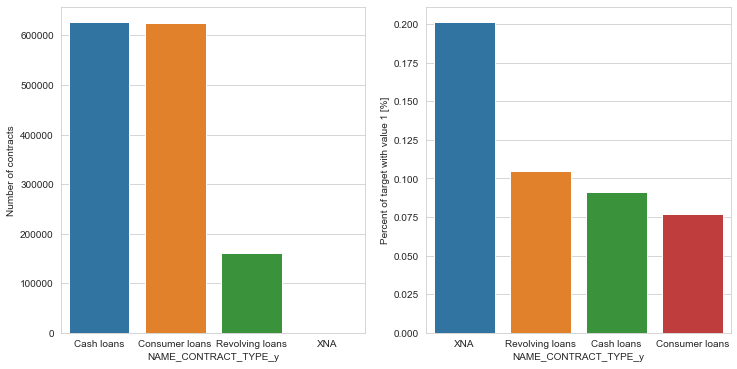

In [94]:
plot_p_stats('NAME_CONTRACT_TYPE_y')

There are three types of contract in the previous application data: Cash loans, Consumer loans, Revolving loans. Cash loans and Consumer loans are almost the same number (~600K) whilst Revolving loans are ~150K.

The percent of defauls loans for clients with previous applications is different for the type of previous applications contracts, decreasing from ~10% for Revolving loans, then ~ 9.5% for Cash loans and ~8% for Consumer loans.

#### Cash loan purpose¶
Let's look to the cash loan purpose, in the case of cash loans.

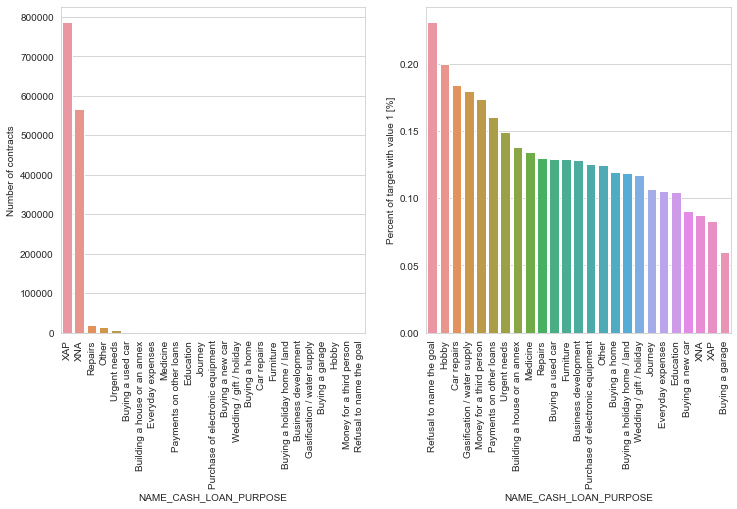

In [95]:
plot_p_stats('NAME_CASH_LOAN_PURPOSE', True, True)

Besides not identifed/not available categories, Repairs, Other, Urgent needs, Buying a used car, Building a house or an annex accounts for the largest number of contracts.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history are previous applications for cash loans for Refusal to name the goal - ~23% (which makes a lot of sense), Hobby (20%), Car repairs (~18%).

#### Contract status
Let's look to the contract status.

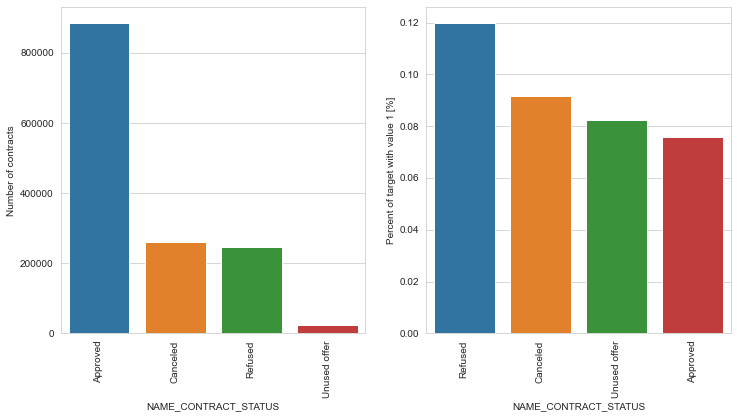

In [96]:
plot_p_stats('NAME_CONTRACT_STATUS', True, True)

Most previous applications contract statuses are Approved (~850K), Canceled and Refused (~240K). There are only ~20K in status Unused offer.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history contract statuses are Refused (12%), followed by Canceled (9%), Unused offer (~8%) and Approved (lowest percent of defaults in current applictions, with less than 8%).

#### |Payment type
Let's check the payment type.

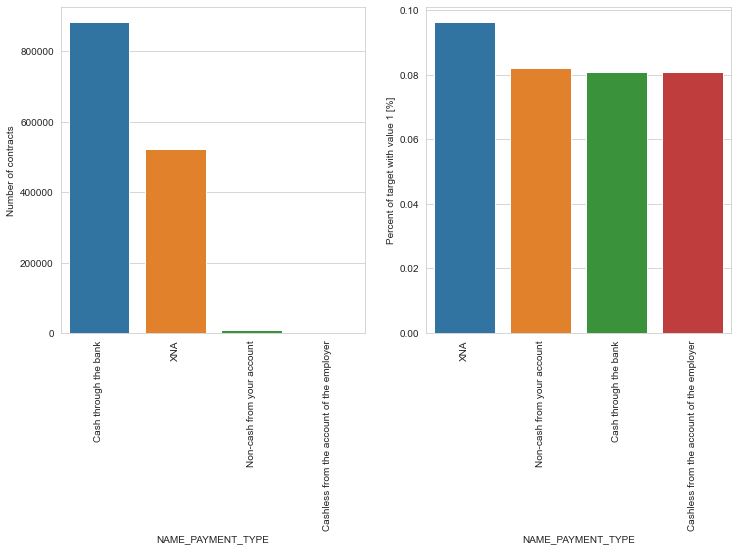

In [97]:
plot_p_stats('NAME_PAYMENT_TYPE', True, True)

Most of the previous applications were paid with Cash through the bank (~850K). Payments using Non-cash from your account or Cashless from the account of the employer are much rare. These three types of payments in previous applications results in allmost the same percent of defaults for current clients (~8% each).

#### Client type¶
Let's check the client type for previous applications.

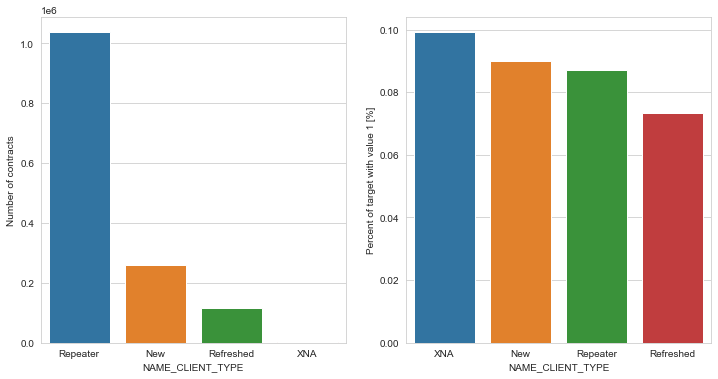

In [98]:
plot_p_stats('NAME_CLIENT_TYPE')

Most of the previous applications have client type Repeater (~1M), just over 200K are New and ~100K are Refreshed.

In terms of default percent for current applications of clients with history of previous applications, current clients with previous applications have values of percent of defaults ranging from from 8.5%, 8.25% and 7% corresponding to client types in the past New, Repeater and Refreshed, respectivelly.